In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

In [2]:
mnist = input_data.read_data_sets('./MNIST_data', one_hot=False)
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.int64, shape=[None])
keep_prob = tf.placeholder(tf.float32, shape=[])
batch_size = 100

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


# Computation graph for classifier on 9 classes and for classifier on 10 classes

Firstly, I trained a classifier on 9 digits: {0,1,2,3,..,8} until test accuracy of 98.5% was achieved.
Then I applied a transfer learning by training only the output layer for classification task on 10 digits.

In [3]:
# ------------------------------------------------------
# Parameters and optimization function for classification on 9 classes
# ------------------------------------------------------

# Convolutional layer
x_image = tf.reshape(x, [-1,28,28,1])
W_conv = tf.Variable(tf.truncated_normal([5, 5, 1, 30], stddev=0.1))
b_conv = tf.Variable(tf.constant(0.1, shape=[30]))
h_conv = tf.nn.conv2d(x_image, W_conv, strides=[1, 1, 1, 1], padding='VALID')
h_relu = tf.nn.relu(h_conv + b_conv)
h_pool = tf.nn.max_pool(h_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], \
                        padding='SAME')
h_pool = tf.nn.dropout(h_pool, keep_prob)

# Fully-connected layer
W_fc1 = tf.Variable(tf.truncated_normal([12 * 12 * 30, 500], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[500]))
h_pool_flat = tf.reshape(h_pool, [-1, 12*12*30])
h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat, W_fc1) + b_fc1)
h_fc1 = tf.nn.dropout(h_fc1, keep_prob)

# Output layer for 9 classes
W_fc2 = tf.Variable(tf.truncated_normal([500, 9], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[9]))
logits = tf.matmul(h_fc1, W_fc2) + b_fc2
y_hat=tf.nn.softmax(logits)

# Train and Evaluate the Model for 9 classes
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits\
                            (logits=logits, labels=y_)
l2 = 0.001* tf.reduce_mean([tf.reduce_mean(tf.nn.l2_loss(W_conv))\
                            , tf.reduce_mean(tf.nn.l2_loss(W_fc1)), \
                            tf.reduce_mean(tf.nn.l2_loss(W_fc2))])
loss = cross_entropy+l2
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y_hat,1), y_)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# ------------------------------------------------------
# Transfer learning parameters and optimization function 
# for classification on 10 classes
# ------------------------------------------------------

# Output layer for 10 classes
W_fc2_10 = tf.Variable(tf.truncated_normal([500, 10], stddev=0.1))
b_fc2_10 = tf.Variable(tf.constant(0.1, shape=[10]))
logits_10 = tf.matmul(h_fc1, W_fc2_10) + b_fc2_10
y_hat_10 =tf.nn.softmax(logits_10)

# Train and Evaluate the Model for 10 classes
cross_entropy_10 = tf.nn.sparse_softmax_cross_entropy_with_logits\
(logits=logits_10, labels=y_)
l2_10 = 0.001* tf.reduce_mean([tf.reduce_mean(tf.nn.l2_loss(W_fc2_10))])
loss_10 = cross_entropy_10+l2_10
train_step_10 = tf.train.AdamOptimizer(1e-4).minimize(loss_10, \
                                        var_list=[W_fc2_10, b_fc2_10])
correct_prediction_10 = tf.equal(tf.argmax(y_hat_10,1), y_)
accuracy_10 = tf.reduce_mean(tf.cast(correct_prediction_10, tf.float32))

# Filter train/valid/test dataset to include all digits except "9"

In [ ]:
train_l = mnist.train.labels[np.where(mnist.train.labels!=9)]
train_i = mnist.train.images[np.where(mnist.train.labels!=9)]
val_l = mnist.validation.labels[np.where(mnist.validation.labels!=9)]
val_i = mnist.validation.images[np.where(mnist.validation.labels!=9)]
test_l = mnist.test.labels[np.where(mnist.test.labels!=9)]
test_i = mnist.test.images[np.where(mnist.test.labels!=9)]
sess.run(tf.global_variables_initializer())

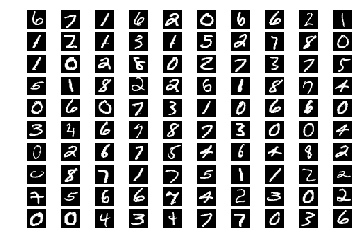

[6 7 1 6 2 0 6 6 2 1 1 2 1 3 1 5 2 7 8 0 1 0 2 8 0 2 7 3 7 5 5 1 8 2 2 6 1
 8 7 4 0 6 0 7 3 1 0 6 6 0 3 4 6 7 8 7 3 0 0 4 0 2 6 7 5 4 6 4 8 2 0 8 7 1
 7 5 1 1 2 2 7 5 6 6 7 4 2 3 0 2 0 0 4 3 4 7 7 0 3 6]


In [10]:
#print('sample of new dataset without digit "9"')
for i in range(10):
    for j in range(10):
        img=train_i[200+i*10+j]
        img.shape=(28,28)
        plt.subplot(10,10,i*10+j+1)
        plt.imshow(img,cmap='gray')
        plt.axis('off')
plt.show()
print(train_l[200:200+100])

In [5]:
n_train = train_i.shape[0]
batches = zip(range(0, n_train-batch_size, batch_size), \
              range(batch_size, n_train, batch_size))
batches = [(start, end) for start, end in batches]

# Train classifier on 9 classes

In [6]:
print("=================================")
print("|    Training for 9 classes     |")
print("|Epoch\tBatch\t|Train\t|Val\t|")
print("|===============================|")
for j in range(10):
    for i, inds in enumerate(batches):
        start, end = inds
        batch_i = train_i[start:end]
        batch_l = train_l[start:end]
        train_step.run(feed_dict={x: batch_i, y_: batch_l, keep_prob:0.7})
        if i%50 == 49:
            train_accuracy = accuracy.eval(feed_dict={x:batch_i,\
                                                y_: batch_l, keep_prob:1})
            val_accuracy = accuracy.eval(feed_dict=\
                {x: val_i, y_:val_l, keep_prob:1})
            print("|%d\t|%d\t|%.4f\t|%.4f\t|"%(j+1, i+1, \
                                            train_accuracy, val_accuracy))
print("|===============================|")
test_accuracy = accuracy.eval(feed_dict=\
    {x: test_i, y_:test_l, keep_prob:1})
print("test accuracy=%.4f"%(test_accuracy))

|    Training for 9 classes      |
|Epoch	Batch	|Train	|Val	|
|===============================|
|1	|50	|0.7800	|0.7465	|
|1	|100	|0.7300	|0.8442	|
|1	|150	|0.8800	|0.8766	|
|1	|200	|0.8400	|0.9019	|
|1	|250	|0.8900	|0.9074	|
|1	|300	|0.9600	|0.9121	|
|1	|350	|0.8900	|0.9190	|
|1	|400	|0.9700	|0.9203	|
|1	|450	|0.8400	|0.9272	|
|2	|50	|0.9800	|0.9307	|
|2	|100	|0.8800	|0.9310	|
|2	|150	|0.9500	|0.9390	|
|2	|200	|0.8900	|0.9438	|
|2	|250	|0.9300	|0.9467	|
|2	|300	|0.9600	|0.9476	|
|2	|350	|0.9300	|0.9514	|
|2	|400	|0.9800	|0.9523	|
|2	|450	|0.9200	|0.9525	|
|3	|50	|0.9800	|0.9578	|
|3	|100	|0.9100	|0.9572	|
|3	|150	|0.9500	|0.9607	|
|3	|200	|0.9200	|0.9640	|
|3	|250	|0.9700	|0.9647	|
|3	|300	|0.9900	|0.9636	|
|3	|350	|0.9500	|0.9651	|
|3	|400	|0.9900	|0.9636	|
|3	|450	|0.9600	|0.9685	|
|4	|50	|1.0000	|0.9689	|
|4	|100	|0.9400	|0.9698	|
|4	|150	|0.9600	|0.9714	|
|4	|200	|0.9400	|0.9711	|
|4	|250	|0.9700	|0.9703	|
|4	|300	|0.9900	|0.9711	|
|4	|350	|0.9600	|0.9723	|
|4	|400	|0.9900	|0.9716	

In [7]:
# assign values from learned 9 neurons to the output layer 
#of transfer learning matrix on 10 classes
sess.run(W_fc2_10[:,:9].assign(W_fc2))
print(sess.run(b_fc2[:30]))
print(sess.run(b_fc2_10[:30]))
print(sess.run(W_fc2_10)[:2,:])
print(sess.run(W_fc2)[:2,:])

[ 0.10030927  0.10443749  0.10152442  0.10139924  0.09753661  0.09999468
  0.09441575  0.09800483  0.10072621]
[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
[[ 0.00453138  0.16689007  0.01384695 -0.0578112  -0.1122089  -0.02734813
  -0.07730881  0.12856545 -0.00265025 -0.00322343]
 [-0.03676954 -0.01936323  0.03572293 -0.0823148   0.0290716  -0.03173323
  -0.16423994  0.07955027 -0.03516648 -0.00861855]]
[[ 0.00453138  0.16689007  0.01384695 -0.0578112  -0.1122089  -0.02734813
  -0.07730881  0.12856545 -0.00265025]
 [-0.03676954 -0.01936323  0.03572293 -0.0823148   0.0290716  -0.03173323
  -0.16423994  0.07955027 -0.03516648]]


# Transfer learning from classifier on 9 classes to classifier on 10 classes

In [8]:
print("=================================")
print("|    Training for 10 classes    |")
print("|Epoch\tBatch\t|Train\t|Val\t|")
print("|===============================|")
for j in range(8):
    for i in range(550):
        batch = mnist.train.next_batch(batch_size)
        train_step_10.run(feed_dict={x: batch[0], y_: batch[1], \
                                     keep_prob:0.7})
        if i%50 == 49:
            train_accuracy = accuracy_10.eval(feed_dict={x:batch[0],\
                                                y_: batch[1], keep_prob:1})
            val_accuracy = accuracy_10.eval(feed_dict=\
                {x: mnist.validation.images, y_:mnist.validation.labels, \
                                                     keep_prob:1})
            print("|%d\t|%d\t|%.4f\t|%.4f\t|"%(j+1, i+1, train_accuracy, \
                                                       val_accuracy))
print("|===============================|")
test_accuracy = accuracy_10.eval(feed_dict=\
    {x: mnist.test.images, y_:mnist.test.labels, keep_prob:1})
print("test accuracy=%.4f"%(test_accuracy))

|    Training for 10 classes     |
|Epoch	Batch	|Train	|Val	|
|===============================|
|1	|50	|0.9100	|0.8892	|
|1	|100	|0.8900	|0.8892	|
|1	|150	|0.8900	|0.8956	|
|1	|200	|0.8700	|0.9058	|
|1	|250	|0.9200	|0.9212	|
|1	|300	|0.9400	|0.9300	|
|1	|350	|0.9100	|0.9378	|
|1	|400	|0.9700	|0.9418	|
|1	|450	|0.9700	|0.9472	|
|1	|500	|0.9400	|0.9520	|
|1	|550	|0.9600	|0.9574	|
|2	|50	|0.9800	|0.9594	|
|2	|100	|0.9700	|0.9606	|
|2	|150	|0.9700	|0.9606	|
|2	|200	|0.9500	|0.9638	|
|2	|250	|0.9700	|0.9654	|
|2	|300	|0.9600	|0.9670	|
|2	|350	|0.9800	|0.9684	|
|2	|400	|0.9600	|0.9692	|
|2	|450	|0.9800	|0.9700	|
|2	|500	|0.9600	|0.9696	|
|2	|550	|0.9700	|0.9700	|
|3	|50	|0.9600	|0.9700	|
|3	|100	|0.9500	|0.9698	|
|3	|150	|0.9600	|0.9710	|
|3	|200	|0.9600	|0.9706	|
|3	|250	|0.9800	|0.9714	|
|3	|300	|0.9700	|0.9718	|
|3	|350	|0.9700	|0.9724	|
|3	|400	|0.9700	|0.9728	|
|3	|450	|0.9700	|0.9722	|
|3	|500	|0.9800	|0.9728	|
|3	|550	|0.9600	|0.9728	|
|4	|50	|0.9900	|0.9734	|
|4	|100	|0.9700	|0.9734	

# Interpretation of the Results

It is quite impressive that just by training the output layer network's accuracy on classifying 10 digits grew from 88% to 97.94% (on validation dataset), so indeed the network learned how to classify a new unseen digit before.

However the final test accuracy on the transfer learning for 10 classes is 97.88% which is good but not as high as it could be while all layers are trained 98.5%.

We can make a conclusion that learning just weights from a final layer and trasfering weights on previous layers from classifier on 9 classes, is not absolutely enough and some useful modifications, which are made in the convolution layer and first fully connected layer while the model is trained on 10 digits without transfer learning, are useful for improving the performance of the classifier.